In [1]:
### %reload_ext autoreload

%reset

import sys
sys.path.append("../")

import numpy as np

import scipy.interpolate
from scipy.stats import poisson
from scipy.stats import uniform
from astropy import units

import matplotlib.pyplot as pl
import matplotlib

import healpy as hp

#For making corner plots
from getdist import plots, MCSamples

import pdb
import time

import EPDFABC as epdfabc
import subhalos as subs
import FermiBackgrounds
import DMsignal

import pickle as pk

import elfi
from elfi.methods.density_ratio_estimation import DensityRatioEstimation
#import graphviz
#elfi.set_client('multiprocessing')    

#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True

import abc_funcs as af

matplotlib.use('PS')

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
channel = 'Tau'
run = 'run1'

#For data generation
logbins = False
if (run == 'generate'):
    load_pf = True
    load_data = False
    save_data = True
    save_posterior = True
    include_bg = True
    vary_DMmass = False
    nbins_summary = 20 #shouldn't matter, but needed to prevent crashing
    N_E_bins = 10
    cmax_summary = 800

# Comparison to exact likelihood
if (run == 'run1'):
    load_pf = True
    load_data = True
    save_data = False
    save_posterior = True
    include_bg = True
    vary_DMmass = False
    N_E_bins = 1
    nbins_summary = 20 #20
    cmax_summary = 240 #240
    max_iter = 5 #5
    
# Showing that adding energy info helps
if (run == 'run2'):
    load_pf = True
    load_data = True
    save_data = False
    save_posterior = True
    include_bg = True
    vary_DMmass = False
    if (channel == 'Tau'):
        N_E_bins = 10
        nbins_summary = 10 #15
        cmax_summary = 150 #75
        max_iter = 2 #5
    if (channel == 'b'):
        N_E_bins = 10
        nbins_summary = 10
        cmax_summary = 120 
        max_iter = 1

# Varying DM mass as well
if (run == 'run3'):
    load_pf = True
    load_data = True
    save_data = False
    save_posterior = True
    include_bg = True
    vary_DMmass = True
    N_E_bins = 10
    nbins_summary = 30 #15
    cmax_summary = 150 #75 # 70 - for tau
    max_iter = 1 #4

if (channel == 'Tau'):
    suffix = 'tau_default_NE10_MMin1_10yr_masked_fixedfov'
    if (run == 'run3'):
        normalize_mean = [200., 1., 200000.]
        normalize_std = [100.0, 0.01, 10000.0]    
    else:
        normalize_mean = [0.0, 0.0, 0.0]
        normalize_std = [1.0, 1.0, 1.0] 
        
if (channel == 'b'):
    suffix = 'b_default_NE10_MMin1_10yr_masked_fixedfov'
    if (run == 'run3'):
        normalize_mean = [6., 1., 50000]
        normalize_std = [1.0, 0.01, 1000.0]    
    else:
        normalize_mean = [0.0, 0.0, 0.0]
        normalize_std = [1.0, 1.0, 1.0]         

        
ABCmethod = 'smc_adap'
distance_metric = 'hist' #'euclidean' #'hist' #'euclidean', 'canberra', 'pdist', 'hist'

In [3]:
my_DM = DMsignal.DMsignal('../data/dm_spectra/', channel)
default_param_dict = my_DM.get_default_model()
default_params = np.array([default_param_dict['A_DM'],\
                           default_param_dict['A_BG'],\
                           default_param_dict['mass_DM_MeV']])
print("default params = ", default_param_dict)

#parameter ranges
if (channel == 'Tau'):    
    param_min_all = np.array([0.2, 0.98, 0.1])*default_params
    param_max_all = np.array([2.5, 1.01, 1.9])*default_params                
if (channel == 'b'):
    #param_min_all = np.array([0.4, 0.993, 0.1])*default_params
    #param_max_all = np.array([1.7, 1.007, 1.9])*default_params  
    param_min_all = np.array([0.2, 0.99, 0.1])*default_params
    param_max_all = np.array([2.5, 1.01, 1.9])*default_params  

    
param_min_all_norm = af.params_to_norm(param_min_all, normalize_mean, normalize_std)
param_max_all_norm = af.params_to_norm(param_max_all, normalize_mean, normalize_std)
print(param_min_all_norm)
print(param_max_all_norm)

param_names_all = np.array(['ADM', 'bgnorm', 'MDM'])
param_labels_all = np.array(['\\A_{DM}', '\\A_{\rm bg}', '\\M_{\chi}'])

if (not include_bg):
    free_indices = np.array([0])
else:
    if (not vary_DMmass):
        free_indices = np.array([0,1])
    else:
        free_indices = np.array([0,1,2])
true_params = default_params[free_indices]   
param_names = param_names_all[free_indices]
param_labels = param_labels_all[free_indices]
param_min = param_min_all[free_indices]
param_max = param_max_all[free_indices]
param_range = [param_min, param_max]
param_min_norm = param_min_all_norm[free_indices]
param_max_norm = param_max_all_norm[free_indices]
param_range_norm = [param_min_norm, param_max_norm]

physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')
print(physics_settings)
print(obs_settings)

count_range = [0,800]
energy_range = [1000, 100000] #this is in MeV, important since used for backgrounds

# Set up background generator
fermi_data_path = '../data/FermiData/'
background_generator = FermiBackgrounds.FermiBackgrounds(fermi_data_path)

#Properties of summary statistic
if (channel == 'Tau'):
    energy_bins_to_use = 'all'

    #77777777777777777777
    if (run == 'run2' or run == 'run3'):
        #energy_bins_to_use = np.array([0,1,2,3,4,5,6])
        #cmax_summary = np.array([120, 70, 50, 30, 20, 10, 10])
        energy_bins_to_use = np.array([0,1,2,3,4,5,6,7,8,9])
        cmax_summary = np.array([160, 100, 70, 50, 50, 50, 50, 50, 40, 40 ])
    
if (channel == 'b'):
    if (run == 'generate' or run == 'run1'):
        energy_bins_to_use = 'all'
    if (run == 'run2' or run == 'run3'):
        #energy_bins_to_use = np.array([0,1,2,3,4,5,6])
        #cmax_summary = np.array([120, 70, 50, 30, 20, 10, 10])
        energy_bins_to_use = np.array([0,1,2,3,4,5,6,7,8,9])
        cmax_summary = np.array([200, 120, 80, 60, 40, 30, 20, 20, 20, 20 ])
summary_properties = {'type': 'histogram' ,'Nbins':nbins_summary, \
                      'Cmax_hist': cmax_summary, 'Cmin_hist': 0, 'logbins':logbins, \
                      'energy_bins_to_use':energy_bins_to_use}

print("free params = ", param_names)

default params =  {'A_DM': 200.0, 'A_BG': 1.0, 'mass_DM_MeV': 200000.0}
[4.0e+01 9.8e-01 2.0e+04]
[5.00e+02 1.01e+00 3.80e+05]
{'R_G': 220, 'd_sun': 8.5, 'M_max': 10000000000.0, 'M_min': 1.0, 'PhiPP': 1.0, 'n': 0, 'beta': 1.9, 'lum_model': 'default', 'l_min': 0.001}
{'area': 2000.0, 'obs_time': 10.0, 'fov_factor': 0.2, 'Omega_pixel': 0.00025566346464760684, 'psi': 1.7453292519943295}
free params =  ['ADM' 'bgnorm']


In [4]:
# Settings for subhalo analysis
default_phipp = physics_settings['PhiPP']
N_pix_fullsky = int(4.*np.pi/obs_settings['Omega_pixel'])
N_side = int(np.sqrt(N_pix_fullsky/12.0))

exposure = ((obs_settings['fov_factor'] * obs_settings['obs_time']*units.yr * obs_settings['area']*units.cm**2).to('s*cm**2')).value
Sangle = obs_settings['Omega_pixel']

print("N_side = ", N_side)

N_side =  64


In [5]:
#sky masking
do_mask = True
if (not do_mask):
    N_pix = N_pix_fullsky
    mask = np.ones(N_pix)
    gal_lat_cut = 0.
    gal_cent_cut = 0.
else:
    gal_lat_cut = 30.
    gal_cent_cut = 60.
    mask = background_generator.get_mask(N_side, gal_lat_cut, gal_cent_cut)
    
    mask_indices = np.where(mask > 0)[0]
    N_pix = len(mask_indices)

In [6]:
# Compute the PDF of photon counts using the Fourier transform trick.  Note that this can be slow.
if (not load_pf):
    maxc = 100.
    counts = np.arange(0,maxc)
    pc, f_pf_precomputed, pf_pf_precomputed = subs.get_pc(counts, physics_settings, fft_settings, \
                                                             obs_settings, return_fpf = True)
    save_pf = True
    if save_pf:
        pf_data = {'maxc':maxc, 'pc':pc, 'counts':counts, 'f_pf_precomputed':f_pf_precomputed, \
                   'pf_pf_precomputed':pf_pf_precomputed}
        pk.dump(pf_data, open('../data/pf_calculation/pf_saved_hires_mmin1_v2.pk','wb'))
else:
    pf_data = pk.load(open('../data/pf_calculation/pf_saved_hires_mmin1.pk','rb'))
    maxc = pf_data['maxc']
    pc = pf_data['pc']
    counts = pf_data['counts']
    
    f_pf_precomputed = pf_data['f_pf_precomputed']
    pf_pf_precomputed = pf_data['pf_pf_precomputed']

In [7]:
#Backgrounds

# Energy spectrum setup
#We use FermiBackgrounds to get the background spectrum and mean flux
fermi_iso = background_generator.get_isotropic_background_spectrum_func()
mean_iso_bg_flux = background_generator.get_masked_isotropic_flux('../data/FermiData/galactic_bg_healpix_Nside64.pk',\
                                                gal_lat_cut, gal_cent_cut, energy_range[0], energy_range[1])

In [8]:
# Set up priors for ELFI

priors = []
for i in np.arange(len(param_names)):
    priors.append(elfi.Prior('uniform', param_min_norm[i], \
                             param_max_norm[i] - param_min_norm[i], name=param_names[i]))
print(priors)

[Prior(name='ADM', 'uniform'), Prior(name='bgnorm', 'uniform')]


In [9]:
# Set up my_abc object

if (include_bg):
    PDF_and_spectra = [[af.background_pdf_wrapper, af.background_spec_wrapper], \
                       [af.subhalo_pdf_wrapper, af.subhalo_spec_wrapper]]
    is_isotropic_list = [True, True]
    is_poisson_list = [False, False]
else:
    PDF_and_spectra = [[af.subhalo_pdf_wrapper, af.subhalo_spec_wrapper]]
    is_isotropic_list = [True]
    is_poisson_list = [False]

# initialize the EPDFABC object
my_abc = epdfabc.EPDFABC(param_range_norm)

#Arguments passed to PDF and spectrum functions
args = {'normalize_mean':normalize_mean, 'normalize_std':normalize_std,\
        'vary_DMmass':vary_DMmass,\
        'default_params':default_params,\
        'energy_range':energy_range,\
        'my_DM':my_DM,\
        'f_pf_precomputed':f_pf_precomputed, 'pf_pf_precomputed':pf_pf_precomputed, \
        'exposure':exposure, \
        'Sangle':Sangle, \
        'mean_iso_bg_flux':mean_iso_bg_flux, \
        'fermi_iso':fermi_iso, \
        'default_phipp':default_phipp
}

#Setup for binned analysis
my_abc.setup_binned(PDF_and_spectra, is_isotropic_list, is_poisson_list, count_range, \
                    energy_range, N_E_bins, obs_settings['Omega_pixel'], verbose = False, args = args)

Generating data...
(1, 20424, 10)
sum =  917783.0
max in energy range =  40.0


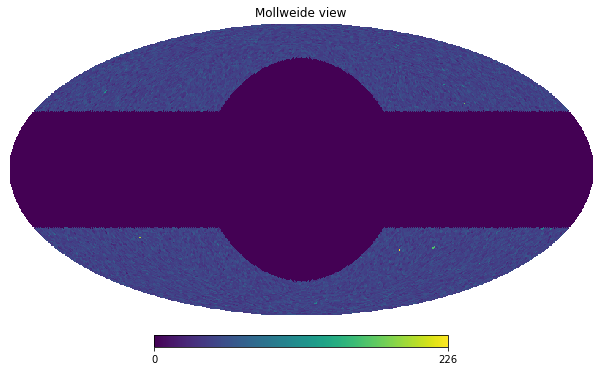

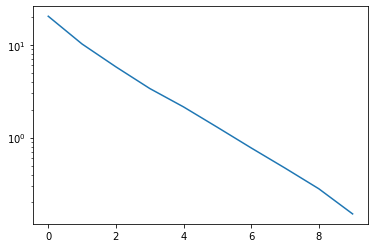

In [10]:
# Get the sky map

if (not load_data):
    print("Generating data...")    
    obs_data = my_abc.generate_mock_data_binned(default_params, N_pix = N_pix)
    if (save_data):
        newskydict = {'physics_settings': physics_settings, 'obs_settings': obs_settings, \
                      'fft_settings': fft_settings, 
               'obs_data': obs_data, 'N_E_bins': N_E_bins, 'maxc': maxc, 'include_bg': include_bg,
                'default_params':default_params, 'channel':channel, 'mask':mask}
        sky_dir = '../data/skymaps/'
        sky_filename = 'skymap_' + suffix + '.pk'
        pk.dump(newskydict, open(sky_dir + sky_filename, 'wb'))
    skydict = newskydict
if (load_data):  
    print("Loading data...")
    sky_dir = '../data/skymaps/'
    sky_filename = 'skymap_' + suffix + '.pk'
    skydict = pk.load(open(sky_dir + sky_filename, 'rb'))
    print(skydict.keys())
    obs_data = skydict['obs_data']
    mask = skydict['mask']
    print("obs data shape = ", obs_data.shape)

#If the number of energy bins desired is 1, then sum over energy bins
if (N_E_bins == 1):
    print("collapsing to 1 energy bin")
    obs_data = np.expand_dims(np.sum(obs_data,axis=2),axis=2)
    
if (N_E_bins == 5):
    print("collapsing to 5 energy bins")
    orig_obs_data = np.copy(obs_data)
    obs_data = np.zeros((1,obs_data.shape[1],5))
    for ii in range(0,5):
        obs_data[0,:,ii] = np.sum(orig_obs_data[0,:,ii*2:ii*2+1], axis = 1)
    

map_to_plot = np.zeros(len(skydict['mask']))
mask_indices = np.where(skydict['mask'] > 0)[0]
map_to_plot[mask_indices] = np.sum(obs_data[0,:,:],axis = 1)
hp.mollview(map_to_plot)
print(obs_data.shape)
print("sum = ", np.sum(obs_data))
print("max in energy range = ", np.max(obs_data[0,:,:]))
fig, ax = pl.subplots(1,1)
ax.plot(np.mean(obs_data[0,:,:],axis = 0))
ax.set_yscale('log')


(1, 20424, 10)
(1, 200)
{'type': 'histogram', 'Nbins': 20, 'Cmax_hist': 800, 'Cmin_hist': 0, 'logbins': False, 'energy_bins_to_use': 'all'}
map dims =  (1, 20424, 10)
summary dims =  (1, 200)
distance =  [2.30944348]


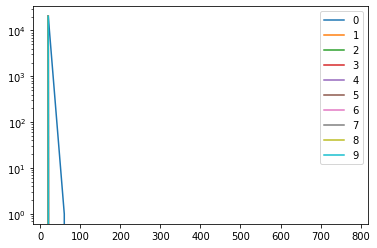

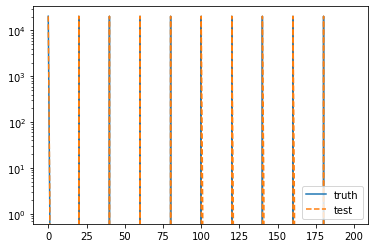

In [11]:
print(obs_data.shape)

# Compare summary at true params to summary of mock data
summary = my_abc.get_summary_from_binned(obs_data, summary_properties = summary_properties)
print(summary.shape)
print(summary_properties)

if (summary_properties['logbins']):
    bins_to_use = np.exp(np.linspace(np.log(summary_properties['Cmin_hist']),np.log(summary_properties['Cmax_hist']), num = summary_properties['Nbins']+1))
else:
    bins_to_use = np.linspace(summary_properties['Cmin_hist'],summary_properties['Cmax_hist'], num = summary_properties['Nbins']+1)
if (not np.isscalar(summary_properties['Cmax_hist'])):
    bins_to_use = np.linspace(summary_properties['Cmin_hist'],np.max(summary_properties['Cmax_hist']), num = summary_properties['Nbins']+1)    
bcents = 0.5*(bins_to_use[1:] + bins_to_use[:-1])

fig, ax = pl.subplots(1,1)
if (np.isscalar(summary_properties['energy_bins_to_use'])):
    num_E_plot = N_E_bins
else:
    num_E_plot = len(summary_properties['energy_bins_to_use'])

for ii in range(0, num_E_plot):
    yy = summary[0,ii*summary_properties['Nbins']:(ii+1)*summary_properties['Nbins']]
    ax.plot(bcents,yy, label = str(ii))
ax.set_yscale('log')
ax.legend()

map_test = my_abc.generate_mock_data_binned( \
                        af.params_to_norm(default_params + np.array([0., 0.0, 0.]), normalize_mean, normalize_std), \
                        N_pix = N_pix)
summary_test = my_abc.get_summary_from_binned(map_test, summary_properties = summary_properties)

print("map dims = ", map_test.shape)
print("summary dims = ", summary_test.shape)
    
fig, ax = pl.subplots(1,1)
ax.plot(summary[0,:], label = 'truth')
ax.plot(summary_test[0,:], ls = 'dashed', label = 'test')
ax.set_yscale('log')
ax.legend()

print("distance = ", af.hist_dist(summary,summary_test))

#hp.mollview(np.sum(map_test[0,:,:], axis =1 ))

In [12]:
#Get posterior using ABC
N_samples = 200
batch_size = 4 #works for run1 4 #16
######elfi######
from functools import partial
fn_simulator = partial(my_abc.generate_mock_data_binned_ELFI, N_pix = N_pix, epdf_object=my_abc, \
                       batch_size = batch_size)
sim = elfi.Simulator(fn_simulator, *priors, observed=obs_data)
summ = elfi.Summary(my_abc.get_summary_from_binned, sim, summary_properties)

if distance_metric == 'pdist':
    d = elfi.Distance(pdist, summ)
elif distance_metric == 'hist':
    d = elfi.Distance(af.hist_dist, summ)
else:
    d = elfi.Distance(distance_metric, summ)

t1 = time.time()

abc_param = 0.0
if ABCmethod == 'rej':#rejection
    rej = elfi.Rejection(d, batch_size = batch_size)
    #elfi.draw(d)
    quantile = 0.05    
    result = rej.sample(N_samples, quantile=quantile)
    abc_param = quantile

if ABCmethod == 'ada_smc':#adaptive distance <--not working
    d.become(elfi.AdaptiveDistance(sim))      
    ada_smc = elfi.AdaptiveDistanceSMC(d, batch_size = batch_size)
    result = ada_smc.sample(N_samples, 2, quantile=0.01)
    
if ABCmethod == 'smc':#sequential monte carlo
    smc = elfi.SMC(d, batch_size = batch_size, seed=1)
    #elfi.draw(d)
    #thresholds = [200., 150., 100.]
    thresholds = [1., 0.1, 0.05]
    result = smc.sample(N_samples, thresholds=thresholds)
    
if ABCmethod == 'smc_adap': #sequential monte carlo adaptive thresholds    
    if (channel == 'Tau' or channel == 'b'):
        #dens_rat = DensityRatioEstimation(optimize = True, n = 50) 
        dens_rat = DensityRatioEstimation(optimize = True, n = 3) 
        smc_adap = elfi.AdaptiveThresholdSMC(d, batch_size = batch_size, q_threshold = 0.995, \
                                             densratio_estimation = dens_rat)
    if (channel == 'b'):
        dens_rat = DensityRatioEstimation(optimize = False, n = 50, epsilon = 0.05) 
        smc_adap = elfi.AdaptiveThresholdSMC(d, batch_size = batch_size, q_threshold = 0.995, \
                                             densratio_estimation = dens_rat)
    #elfi.draw(d)
    result = smc_adap.sample(N_samples, max_iter = max_iter)
    #what does this do?
    result.summary(all=True)
    abc_param = max_iter
    
if ABCmethod == 'internal': #rejection sampling implemented internally to EPDFABC
    posterior_samples = my_abc.run_abc_binned(obs_data, N_samples, summary_properties, \
                                              epsilon = 10000., verbose = True)

    
t2 = time.time()
print("total time = ", t2-t1)


ABC-SMC Round 1 / 2
Progress [==================================================] 100.0% Complete
ABC-SMC Round 2 / 2
Progress [==================================================] 100.0% Complete
Method: AdaptiveThresholdSMC
Number of samples: 200
Number of simulations: 6540
Threshold: 5.22
Sample means: ADM: 202, bgnorm: 1

Population 0:
Method: Rejection within SMC-ABC
Number of samples: 200
Number of simulations: 1000
Threshold: 7.21
Sample means: ADM: 211, bgnorm: 1

Population 1:
Method: Rejection within SMC-ABC
Number of samples: 200
Number of simulations: 5540
Threshold: 5.22
Sample means: ADM: 202, bgnorm: 1
total time =  929.2334282398224


In [13]:
#Get posterior samples

#keys = list(result.samples)
#if np.size(keys) == 1:
#    posterior_samples = result.samples[keys[0]]
#else:
posterior_samples = np.zeros((N_samples, np.size(param_names)))
for si in range(0,N_samples):
    norm_si = np.zeros(np.size(param_names))
    for i in np.arange(np.size(param_names)):
        norm_si[i] = result.samples[param_names[i]][si]
    posterior_samples[si,:] = af.norm_to_params(norm_si, normalize_mean, normalize_std)
weights = result.weights

print("posterior samples shape = ", posterior_samples.shape)

if (save_posterior):
    save_ABC_dir = '../data/ABC_posteriors/'
    save_ABC_filename = 'abc_nrgybin' + str(N_E_bins) + '_' + ABCmethod + str(abc_param) + '_nsamp' + \
        str(N_samples) + '_withbg' + str(include_bg) + '_varyMx' + \
        str(vary_DMmass) + '_nparam' + str(len(param_names)) + '_' + suffix + '_' + run + \
        '_nbinssum' + str(nbins_summary) + '_maxiter' + str(max_iter) + '_batch' +str(batch_size) +'_rebin_n301.pk'
    print(save_ABC_filename)
    save_ABC_data = {'samples': posterior_samples, 'true_params': true_params, \
                     'weights':weights,\
                     'param_names':param_names,\
                    'param_min':param_min,\
                    'param_max':param_max}
    pk.dump(save_ABC_data, open(save_ABC_dir + save_ABC_filename, 'wb'))

posterior samples shape =  (200, 2)
abc_nrgybin10_smc_adap2_nsamp200_withbgTrue_varyMxFalse_nparam2_tau_default_NE10_MMin1_10yr_masked05_run2_nbinssum5_maxiter2_batch4_rebin_5count_n301.pk


{'ADM': [40.0, 500.0], 'bgnorm': [0.99, 1.01], 'MDM': [20.0, 380.0]}
Removed no burn in


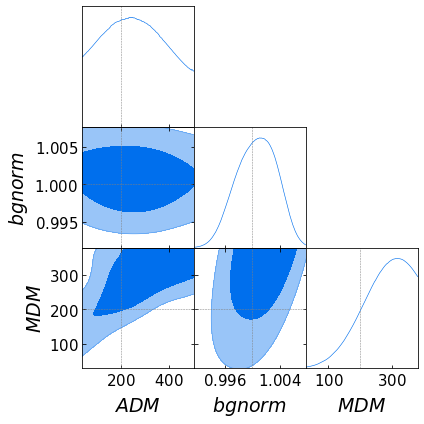

In [15]:
if (1):
    samples_to_use = np.copy(posterior_samples)
    #Getdist requires specification of parameter ranges to get accurate contours
    ranges = {}
    markers={} #true parameter values
    for ii in range(0,len(param_min)):
        ranges[param_names[ii]] = [param_min[ii], param_max[ii]]
        markers[param_names[ii]] = true_params[ii]
        if (ii == 2):
            ranges[param_names[ii]] = [param_min[ii]/1000., param_max[ii]/1000.]
            markers[param_names[ii]] = true_params[ii]/1000.
            
    
    if (len(param_names) > 2):
        samples_to_use[:,2] = posterior_samples[:,2]/1000.
        
    print(ranges)
        
    psamps = MCSamples(samples = samples_to_use, weights = result.weights, \
                       ranges = ranges, names = param_names, labels = param_names)
    #psamps.updateSettings({'contours': [0.68, 0.95, 0.99]})
    #print(psamps.settings)
    
    g = plots.get_subplot_plotter()
    g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
    g.settings.axes_fontsize=18
    g.settings.legend_fontsize = 26
    g.settings.axes_labelsize = 22
    g.triangle_plot(psamps, filled=True, markers=markers)

In [14]:
b
run1
Population 4:
Method: Rejection within SMC-ABC
Number of samples: 400
Number of simulations: 5539136
Threshold: 1.86
Sample means: ADM: 5.15, bgnorm: 1
total time =  13133.117734193802



run2
Population 2:
Method: Rejection within SMC-ABC
Number of samples: 400
Number of simulations: 7472
Threshold: 4.2
Sample means: ADM: -0.983, bgnorm: -0.0164
total time =  292.3866620063782


run1 16 batch
nbins_summary = 20
cmax_summary = 240

Population 4:
Method: Rejection within SMC-ABC
Number of samples: 200
Number of simulations: 13089040
Threshold: 1.86
Sample means: ADM: 236, bgnorm: 0.999
total time =  15280.238472700119




run 2  16 batch
nbins_summary = 15
cmax_summary = 70

Population 4:
Method: Rejection within SMC-ABC
Number of samples: 200
Number of simulations: 1151296
Threshold: 5.86
Sample means: ADM: 208, bgnorm: 1
total time =  28617.211879253387



















#run1

25 bin
Number of simulations: 10168
Threshold: 3.82
Sample means: ADM: 0.38, bgnorm: -1.41
total time =  61.804296255111694
normalize_mean = [200., 1., 0.]
normalize_std =[100.0, 0.001, 1.0] #7777777
    



Population 1:
Method: Rejection within SMC-ABC
Number of samples: 200
Number of simulations: 10612
Threshold: 3.82
Sample means: ADM: 229, bgnorm: 0.999
total time =  68.10485053062439
normalize_mean = [0.0, 0.0, 0.0] #[200., 1., 0.]
normalize_std = [1.0, 1.0, 1.0] #[100.0, 0.001, 1.0] #7777777



#batch = 1



Population 1:
Method: Rejection within SMC-ABC
Number of samples: 200
Number of simulations: 8189
Threshold: 3.9
Sample means: ADM: 232, bgnorm: 0.999
total time =  78.31771874427795




-----------------------------------

Population 1:
Method: Rejection within SMC-ABC
Number of samples: 200
Number of simulations: 19220
Threshold: 5.24
Sample means: ADM: 227, bgnorm: 0.999
total time =  157.7696554660797



# run 2

Population 1:
Method: Rejection within SMC-ABC
Number of samples: 200
Number of simulations: 3352
Threshold: 9.17
Sample means: ADM: 211, bgnorm: 1
total time =  717.102623462677



Population 1:
Method: Rejection within SMC-ABC
Number of samples: 200
Number of simulations: 11836
Threshold: 9.19
Sample means: ADM: 29.9, MDM: 23.6, bgnorm: 1
total time =  2079.047325849533

SyntaxError: invalid syntax (<ipython-input-14-2e9571f5c191>, line 1)

[5.e+00 1.e+00 5.e+04]
1.0
{'R_G': 220, 'd_sun': 8.5, 'M_max': 10000000000.0, 'M_min': 1.0, 'PhiPP': 1.0, 'n': 0, 'beta': 1.9} {'minF': 1e-16, 'maxF': 100000.0, 'numF': 4096, 'minlnk': -6.907755278982137, 'maxlnk': 15.424948470398373, 'numk': 8192, 'minf_out': 1e-05, 'maxf_out': 0.001, 'numf_out': 512, 'minf_pc': 1e-05, 'maxf_pc': 0.0008} {'area': 2000.0, 'obs_time': 10.0, 'fov_factor': 0.2, 'Omega_pixel': 0.00025566346464760684, 'psi': 1.7453292519943295}


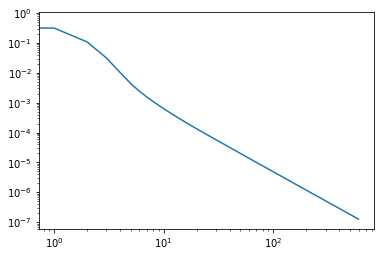

In [85]:
print(default_params)
print(default_phipp)
print(physics_settings, fft_settings, obs_settings)

cc = np.arange(0,600)
pc_dm = af.subhalo_pdf_wrapper(default_params, cc, args)
fig, ax = pl.subplots(1,1)
ax.plot(cc, pc_dm)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim((5.0e-6, 5.0))

In [16]:
28617/3600.

7.949166666666667